In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd

In [2]:
df = pd.read_csv('C:/GitHub/kaggle/digit-recognizer/data/train.csv', sep=',', header=0)
print(df.info())
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def split_data(df):

    train=df.sample(frac=0.8,random_state=42)
    val=df.drop(train.index)
    
    return train, val

In [4]:
df_train, df_val = split_data(df)

In [5]:
def restore_dimensions(df, prediction=False):   
    
    X = df.loc[:, 'pixel0':'pixel783']
    X = X.values 
    m = X.shape[0]   
    X = np.reshape(X, (m, 28, 28, 1))
    
    if prediction:
        Y = None
    else:
        y = df.loc[:, 'label']
        Y = pd.get_dummies(y, columns = ['label'])
        Y  = Y.values
        Y = np.reshape(Y, (m, 10))
            
    return X, Y

In [6]:
X_train, Y_train = restore_dimensions(df_train)
X_val, Y_val = restore_dimensions(df_val)

print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of validation examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))

Number of training examples = 33600
Number of validation examples = 8400
X_train shape: (33600, 28, 28, 1)
Y_train shape: (33600, 10)
X_val shape: (8400, 28, 28, 1)
Y_val shape: (8400, 10)


In [7]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0), name='X')
    Y = tf.placeholder(tf.float32, shape=(None, n_y), name='Y')
    
    return X, Y

In [9]:
n_H = X_train.shape[1]
n_W = X_train.shape[2]
n_C = 1
n_y = Y_train.shape[1]

X, Y = create_placeholders(n_H, n_W, n_C, n_y)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X_1:0", shape=(?, 28, 28, 1), dtype=float32)
Y = Tensor("Y_1:0", shape=(?, 10), dtype=float32)


In [10]:
def initialize_parameters():
  
    # Init variables with xavier initializers - prevents weights from being too small/big
    W1 = tf.get_variable("W1", [4, 4, 1, 8], initializer = tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer())

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [11]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    
    print("W1 = " + str(parameters["W1"].eval()[1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

Instructions for updating:
Use the retry module or similar alternatives.
W1 = [[-0.1580479  -0.16130143 -0.14990367 -0.18879274  0.00317255  0.04239197
   0.19033411 -0.14808246]]
W2 = [ 0.05945182 -0.24659145 -0.23628843  0.19142652 -0.01223731  0.03257239
  0.00916171 -0.17187983  0.04244643 -0.10146749 -0.10593873  0.044186
 -0.06422544  0.05488336  0.05805546  0.19174701]


In [12]:
def forward_propagation(X, parameters):

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME', name='Z1')
    
    # RELU
    A1 = tf.nn.relu(Z1, name='A1')
    
    # MAXPOOL: window 4x4, sride 2, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME', name='P1')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME', name='Z2')
    
    # RELU
    A2 = tf.nn.relu(Z2, name='A2')
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME', name='P2')
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    
    # FULLY-CONNECTED: 40 units, RelU activation
    Z3 = tf.contrib.layers.fully_connected(P2, 40, activation_fn=tf.nn.relu, scope='Z3')
    
    # FULLY-CONNECTED-OUTPUT: 10 units, no activation (is in cost function)
    Z4 = tf.contrib.layers.fully_connected(Z3, 10, activation_fn=None, scope='Z4')

    return Z4

In [13]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y= X, Y = create_placeholders(n_H, n_W, n_C, n_y)
    parameters = initialize_parameters()
    Z = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z, {X: np.random.randn(1,n_H,n_W,n_C), Y: np.random.randn(1,n_y)})
    print("Z = " + str(a))

Z = [[-0.69819105  0.44099775 -1.7828609   1.2550921  -0.36044133 -0.86019313
  -0.9017037   0.05264278  0.1788131  -0.2635119 ]]


In [14]:
def compute_cost(Z, Y):
    
     # Define a sigmoid based discrete classifier as a loss function
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z, labels=Y, name='loss')
    
    # Define a function to measure cost
    cost = tf.reduce_mean(loss, name='cost')
    
    return cost

In [15]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(n_H, n_W, n_C, n_y)
    parameters = initialize_parameters()
    Z = forward_propagation(X, parameters)
    cost = compute_cost(Z, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, feed_dict={X: np.random.randn(100, n_H, n_W, n_C), Y: np.random.randn(100, n_y)})
    print("cost = " + str(a))

cost = -0.434353


In [16]:
def random_mini_batches(X_train, Y_train, minibatch_size, seed):

    # Shuffle with identical seed to get same shuffle in both X and Y
    np.random.seed(seed)
    X_train = np.random.permutation(X_train)
    
    np.random.seed(seed)
    Y_train = np.random.permutation(Y_train)
    
    m = X_train.shape[0]
    num_minibatches = int(m / minibatch_size)
    
    # Split data into smaller batches for ready for stochastic gradient descent
    minibatches_X = np.array_split(X_train, num_minibatches)
    minibatches_Y = np.array_split(Y_train, num_minibatches)
    
    minibatches = zip(minibatches_X, minibatches_Y)
    
    return minibatches

In [17]:
def model(X_train, Y_train, X_val, Y_val, learning_rate = 0.009, num_epochs = 100, 
          minibatch_size = 32, print_cost = True, save_path = './'):
    
    ops.reset_default_graph()                      
    tf.set_random_seed(42)                            
    seed = 42                                         
    (m, n_H0, n_W0, n_C0) = X_train.shape  
    n_y = Y_val.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    #Create a saver object which will save all the variables
    saver = tf.train.Saver()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        val_accuracy = accuracy.eval({X: X_val, Y: Y_val})
        print("Train Accuracy:", train_accuracy)
        print("Validation Accuracy:", val_accuracy)
        
        #Save the graph
        saver.save(sess, save_path)
                
        return val_accuracy, val_accuracy, parameters

Cost after epoch 0: 1.166293
Cost after epoch 5: 0.152251
Cost after epoch 10: 0.129642
Cost after epoch 15: 0.129652
Cost after epoch 20: 0.125055
Cost after epoch 25: 0.123699
Cost after epoch 30: 0.123392
Cost after epoch 35: 0.125963


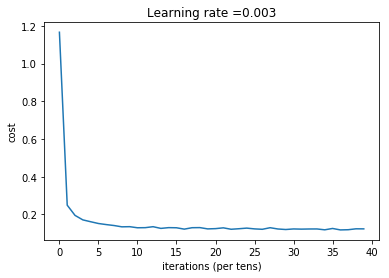

Tensor("Mean:0", shape=(), dtype=float32)
Train Accuracy: 0.9719345
Validation Accuracy: 0.9628571


In [18]:
_, _, parameters = model(X_train, 
                         Y_train, 
                         X_val, 
                         Y_val,
                         learning_rate = 0.003,
                         num_epochs=40, 
                         save_path='C:/GitHub/kaggle/digit-recognizer/models/digit_recognizer')